In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
import torch                     # for all things PyTorch
import torch.nn as nn            # for torch.nn.Module, the parent object for PyTorch models
import torch.nn.functional as F  # for the activation function
import statsmodels.api as sm
import random

In [2]:
stock_data = pd.read_pickle('usa_131_per_size_ranks_False.pkl')
stock_data.shape, stock_data.columns

((2487008, 135),
 Index(['id', 'date', 'size_grp', 'cowc_gr1a', 'oaccruals_at', 'oaccruals_ni',
        'taccruals_at', 'taccruals_ni', 'debt_gr3', 'fnl_gr1a',
        ...
        'div12m_me', 'ebitda_mev', 'eq_dur', 'eqnpo_12m', 'eqnpo_me', 'eqpo_me',
        'ni_me', 'ocf_me', 'sale_me', 'r_1'],
       dtype='object', length=135))

In [3]:
stock_data

,id,date,size_grp,cowc_gr1a,oaccruals_at,oaccruals_ni,taccruals_at,taccruals_ni,debt_gr3,fnl_gr1a,...,div12m_me,ebitda_mev,eq_dur,eqnpo_12m,eqnpo_me,eqpo_me,ni_me,ocf_me,sale_me,r_1
0,10006,1963-01-31,large,0.070236,0.420000,0.478462,-0.392308,-0.430769,0.452528,0.479282,...,-0.122528,0.095568,-0.256881,-0.162338,0.000000,0.000000,-0.147790,-0.465470,0.103591,0.036440
1,10014,1963-01-31,micro,0.488873,0.444615,0.446154,0.423077,0.438462,0.000000,0.411602,...,-0.500000,-0.127424,-0.143731,-0.409091,0.000000,0.000000,0.064917,-0.469613,0.232044,-0.035593
2,10102,1963-01-31,large,0.128651,0.349231,0.350769,0.226154,0.309231,0.163571,0.313536,...,0.138865,-0.159280,0.168196,-0.461039,0.000000,0.000000,-0.220994,-0.325967,-0.222376,-0.006685
3,10145,1963-01-31,mega,-0.168985,0.238462,0.226154,0.349231,0.344615,-0.207946,-0.207182,...,-0.009028,-0.220222,0.279817,-0.478896,0.000000,0.000000,-0.299724,-0.218232,-0.317680,-0.036420
4,10153,1963-01-31,large,-0.376217,-0.256923,-0.210769,-0.260000,-0.172308,-0.096491,-0.070442,...,0.221410,-0.336565,-0.481651,0.405844,0.000000,0.000000,-0.277624,0.088398,0.338398,-0.024319
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2487003,93426,2022-11-30,small,0.000435,0.185551,0.202183,0.139719,0.141966,0.318271,-0.105762,...,-0.500000,0.198782,-0.103350,0.041766,-0.093366,-0.227869,0.153088,0.079917,0.120158,-0.050705
2487004,93427,2022-11-30,large,0.375254,0.370062,0.345114,0.340135,0.300832,-0.398225,-0.200753,...,-0.500000,-0.053451,0.083755,0.081543,0.056281,-0.013115,0.069279,-0.075246,0.012934,-0.042282
2487005,93434,2022-11-30,micro,-0.448941,-0.377339,-0.098233,-0.340915,-0.063703,0.274955,0.195302,...,-0.500000,-0.405277,0.441530,-0.372713,-0.437582,-0.096995,-0.456668,-0.426310,0.310213,0.338963
2487006,93436,2022-11-30,mega,-0.318103,-0.224532,-0.091476,0.188329,0.169527,-0.409950,-0.399040,...,-0.500000,-0.179026,0.252528,-0.310925,-0.186602,-0.381967,-0.070835,-0.085106,-0.353505,-0.370713


In [4]:
len(stock_data.date.unique())

719

In [5]:
stock_data.shape[0] / len(stock_data.date.unique())

3458.981919332406

In [6]:
size_group = 'mega'
if size_group is not None:
  stock_data = stock_data.loc[stock_data.size_grp==size_group]
  
stock_data['div12m_me'].describe()

count    243906.000000
mean          0.063832
std           0.295437
min          -0.500000
25%          -0.079077
50%           0.118972
75%           0.294380
max           0.500000
Name: div12m_me, dtype: float64

In [7]:
stock_data.set_index(['id', 'date'], inplace=True)
print(stock_data.iloc[10,:])

size_grp            mega
cowc_gr1a      -0.061892
oaccruals_at   -0.127692
oaccruals_ni   -0.107692
taccruals_at       -0.06
                  ...   
eqpo_me              0.0
ni_me           0.339779
ocf_me          0.175414
sale_me        -0.009669
r_1             -0.01026
Name: (10786, 1963-01-31 00:00:00), Length: 133, dtype: object


In [8]:
size_groups = stock_data.pop('size_grp')
stock_data.dtypes.unique()

array([dtype('float32'), dtype('float64')], dtype=object)

In [9]:
# the simplest are momentum signals
momentum_columns = [x for x in stock_data.columns if 'ret' in x]
print(momentum_columns)

['ret_12_1', 'ret_3_1', 'ret_6_1', 'ret_9_1', 'ret_12_7', 'ret_1_0']


In [10]:
def build_managed_returns(returns, signals):
  # I am using numpy broadcasting here
  managed_returns = (signals * returns.values.reshape(-1, 1)).groupby(signals.index.get_level_values('date')).sum()
  return managed_returns

momentum_managed_returns = build_managed_returns(returns=stock_data['r_1'], signals=stock_data[momentum_columns])

# get stock data on that particular date
dat = stock_data.loc[stock_data.index.get_level_values('date')=='2022-11-30']
dat

,,cowc_gr1a,oaccruals_at,oaccruals_ni,taccruals_at,taccruals_ni,debt_gr3,fnl_gr1a,ncol_gr1a,nfna_gr1a,noa_at,...,div12m_me,ebitda_mev,eq_dur,eqnpo_12m,eqnpo_me,eqpo_me,ni_me,ocf_me,sale_me,r_1
id,date,,,,,,,,,,,,,,,,,,,,,
10104,2022-11-30,-0.027415,-0.003898,-0.062890,-0.232259,-0.256110,0.128725,-0.401376,-0.367711,-0.299377,-0.178779,...,0.107389,0.004465,0.000000,0.200610,0.387438,0.369945,0.002854,0.012195,-0.265849,-0.018916
10107,2022-11-30,-0.155352,-0.117204,0.066788,-0.226020,-0.022881,-0.180671,-0.221256,-0.069191,-0.249546,-0.184012,...,0.027151,-0.070771,0.172566,0.108592,0.122356,0.068306,0.050597,0.032434,-0.358866,-0.063424
10138,2022-11-30,-0.446910,-0.273649,-0.045998,-0.214323,-0.013001,0.254437,0.106800,0.408326,-0.086556,0.057558,...,0.370125,0.276455,-0.121365,0.266375,0.415383,0.395082,0.272185,0.277374,-0.187843,-0.120663
10145,2022-11-30,0.120249,0.278846,0.271310,0.287367,0.272751,0.022228,-0.346354,0.188715,0.251882,-0.133140,...,0.152174,-0.078349,0.169722,0.281756,0.240141,0.203279,0.028801,-0.044629,-0.218938,-0.027292
10516,2022-11-30,-0.129823,0.293919,0.297817,0.265792,0.280031,0.041443,0.176356,-0.029156,0.201531,-0.086047,...,0.127916,0.104871,-0.097661,0.240122,0.081875,0.015301,0.201090,0.064349,0.338091,-0.051071
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93089,2022-11-30,0.131854,0.270010,0.249220,-0.048219,0.043422,0.101042,0.242798,-0.146359,-0.224630,0.174128,...,-0.020620,-0.098917,0.205752,0.240652,0.227605,0.211749,0.040218,-0.026207,-0.358062,-0.041374
93094,2022-11-30,0.188715,-0.269751,-0.260395,0.025604,0.035881,0.192558,-0.382948,-0.266754,0.323774,0.081686,...,0.110002,0.396346,0.130215,0.355211,0.225255,0.198087,0.269590,0.361183,0.276974,-0.023627
93096,2022-11-30,0.102263,0.147609,0.185031,-0.119704,-0.089184,0.125794,0.269011,0.175950,-0.247989,0.313081,...,0.001026,-0.071042,0.156448,0.274596,0.229433,0.181421,0.062532,0.015828,0.090671,-0.038110


In [11]:
dat.describe()

,cowc_gr1a,oaccruals_at,oaccruals_ni,taccruals_at,taccruals_ni,debt_gr3,fnl_gr1a,ncol_gr1a,nfna_gr1a,noa_at,...,div12m_me,ebitda_mev,eq_dur,eqnpo_12m,eqnpo_me,eqpo_me,ni_me,ocf_me,sale_me,r_1
count,491.000000,491.000000,491.000000,491.000000,491.000000,491.000000,491.000000,491.000000,491.000000,491.000000,...,491.000000,491.000000,491.000000,491.000000,491.000000,491.000000,491.000000,491.000000,491.000000,491.000000
mean,-0.052908,-0.001719,-0.047076,-0.009019,-0.035323,0.022360,-0.019868,0.000931,0.009065,0.016818,...,0.005661,0.030148,0.031383,0.157303,0.149959,0.117268,0.085523,0.101873,-0.088139,-0.054560
std,0.223547,0.225711,0.256278,0.227065,0.251815,0.221454,0.258461,0.282684,0.244894,0.234277,...,0.326253,0.184399,0.201656,0.224917,0.194797,0.206623,0.169297,0.174273,0.222594,0.061589
min,-0.497679,-0.485967,-0.497661,-0.484403,-0.494020,-0.500000,-0.467817,-0.491007,-0.490657,-0.479651,...,-0.500000,-0.420704,-0.491466,-0.487271,-0.453252,-0.381967,-0.391282,-0.424235,-0.433119,-0.428161
25%,-0.217000,-0.172687,-0.265982,-0.180400,-0.264171,-0.132470,-0.258370,-0.252538,-0.183104,-0.144331,...,-0.500000,-0.098106,-0.097819,0.056219,0.029642,0.000000,-0.027893,-0.036066,-0.272819,-0.088620
50%,-0.054975,-0.001040,-0.045998,-0.004289,-0.009620,0.009200,-0.015183,-0.002466,0.013626,0.004360,...,0.082758,0.000000,0.062895,0.197163,0.173544,0.140437,0.054489,0.076284,-0.116807,-0.048226
75%,0.102118,0.156965,0.185291,0.171757,0.171542,0.192884,0.172333,0.264868,0.218401,0.185029,...,0.256858,0.126116,0.184735,0.319676,0.298773,0.280191,0.184094,0.234821,0.062659,-0.015320
max,0.484914,0.487786,0.495842,0.462828,0.496100,0.493486,0.492733,0.488106,0.446535,0.498547,...,0.488057,0.492693,0.497788,0.496553,0.488248,0.484699,0.495330,0.475610,0.482844,0.131330


In [12]:
# let us see the magic of numpy broadcasting
tmp = dat['r_1'].values.reshape(-1, 1) * dat[momentum_columns]
print(tmp)

                  ret_12_1   ret_3_1   ret_6_1   ret_9_1  ret_12_7   ret_1_0
id    date                                                                  
10104 2022-11-30 -0.001199 -0.003909 -0.004473 -0.004551  0.001400 -0.002150
10107 2022-11-30  0.007098  0.014394  0.010967  0.006658  0.002285 -0.015321
10138 2022-11-30  0.030174  0.025534  0.021273  0.016583  0.034091 -0.045116
10145 2022-11-30 -0.006026 -0.007087 -0.005082 -0.007895 -0.004109 -0.004759
10516 2022-11-30 -0.023085 -0.015597 -0.010533 -0.020027 -0.023743  0.004201
...                    ...       ...       ...       ...       ...       ...
93089 2022-11-30 -0.000038  0.000360 -0.007133 -0.009780 -0.002768  0.004122
93094 2022-11-30 -0.011041 -0.006369  0.003132 -0.009735 -0.011259  0.003746
93096 2022-11-30 -0.012554 -0.009817 -0.011880 -0.015613 -0.011612  0.004282
93132 2022-11-30 -0.004094 -0.033435 -0.002529  0.004141 -0.000453  0.024911
93436 2022-11-30  0.079215  0.122560  0.036685  0.037460  0.056991  0.140821

In [13]:
factor_returns_on_the_date = tmp.sum()
factor2 = momentum_managed_returns.loc['2022-11-30']
tmp1 = pd.concat([factor_returns_on_the_date, factor2], axis=1)
print(tmp1)

                 0  2022-11-30 00:00:00
ret_12_1 -1.180183            -1.180183
ret_3_1  -0.734016            -0.734016
ret_6_1  -0.516045            -0.516045
ret_9_1  -1.031057            -1.031057
ret_12_7 -1.121620            -1.121620
ret_1_0  -2.047559            -2.047559


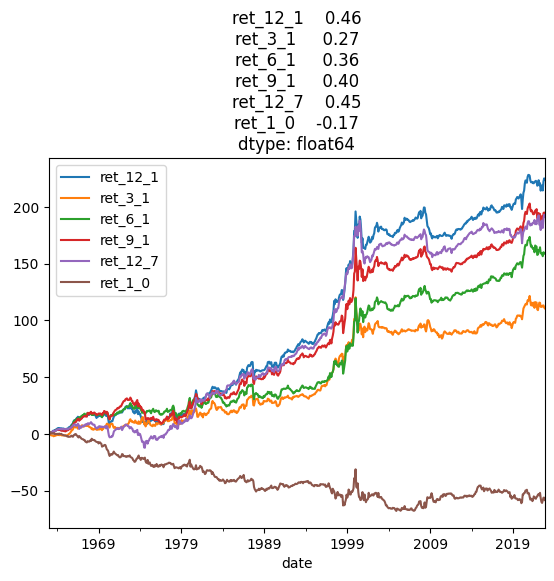

In [14]:
def sharpe_ratio(returns):
  """
  The data is at monthly frequency, hence we multiply by sqrt(12)
  """
  return np.round(np.sqrt(12) * returns.mean() / returns.std(), 2)

momentum_managed_returns.cumsum().plot()
sr = sharpe_ratio(momentum_managed_returns)
plt.title(f'{sr}')
plt.show()

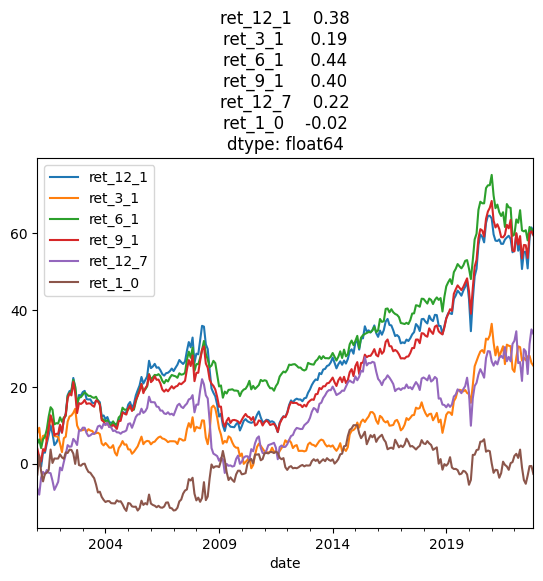

In [15]:
momentum_managed_returns.loc['2001-01-01':].cumsum().plot()
sr = sharpe_ratio(momentum_managed_returns.loc['2001-01-01':])
plt.title(f'{sr}')
plt.show()

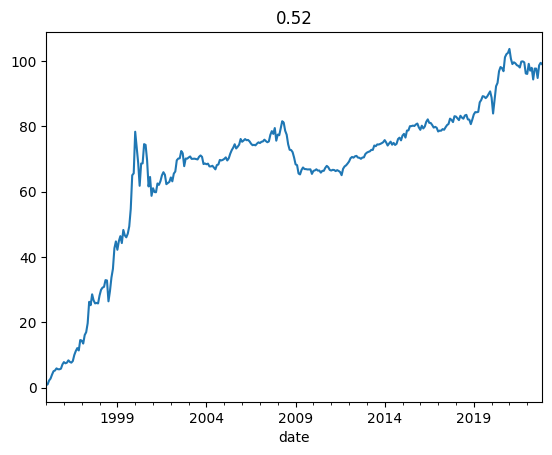

In [16]:
simple_benchmark = (momentum_managed_returns * np.sign(momentum_managed_returns.shift(1).expanding().sum())).mean(1)
simple_benchmark.loc['1995-01-01':].cumsum().plot()
sr = sharpe_ratio(simple_benchmark.loc['1995-01-01':])
plt.title(f'{sr}')
plt.show()

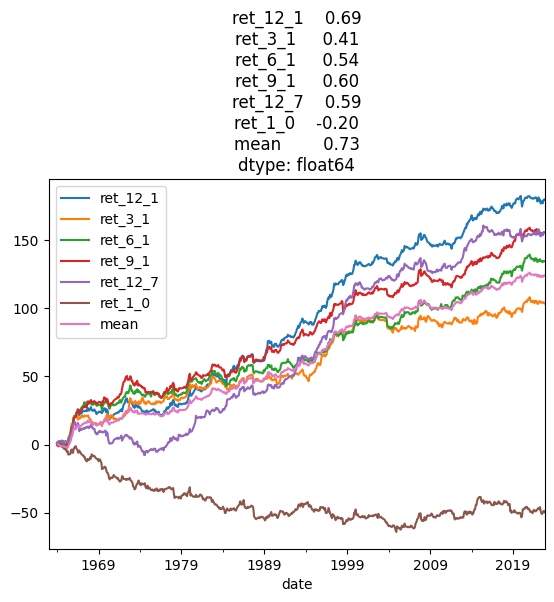

In [17]:
def volatility_managed_returns(rets, window):
  return rets / rets.rolling(window).std().shift(1)

# let us do risk-managed momentum following "Momentum has its moments"
managed = volatility_managed_returns(momentum_managed_returns, 12)
simple_managed_benchmark = (managed * np.sign(managed.shift(1).expanding().sum())).mean(1)
managed['mean'] = simple_managed_benchmark
managed.cumsum().plot()
sr = sharpe_ratio(managed)
plt.title(f'{sr}')
plt.show()

In [18]:
market = stock_data.r_1.groupby('date').mean()
tmp = pd.concat([market, simple_benchmark, simple_managed_benchmark], axis=1)
print(tmp.corr())

          r_1         0         1
r_1  1.000000  0.402288  0.407739
0    0.402288  1.000000  0.782688
1    0.407739  0.782688  1.000000


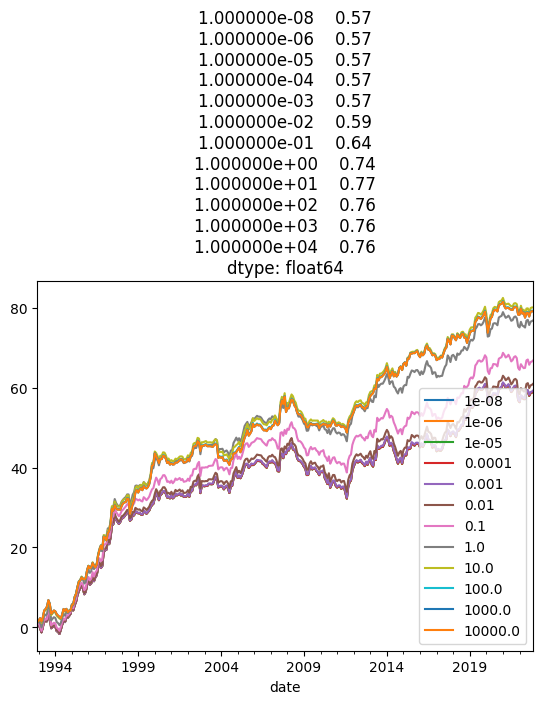

In [19]:
def ridge_regr(signals: np.ndarray,
                  labels: np.ndarray,
                  future_signals: np.ndarray,
                  shrinkage_list: np.ndarray):
    """
    Regression is
    beta = (zI + S'S/t)^{-1}S'y/t = S' (zI+SS'/t)^{-1}y/t
    Inverting matrices is costly, so we use eigenvalue decomposition:
    (zI+A)^{-1} = U (zI+D)^{-1} U' where UDU' = A is eigenvalue decomposition,
    and we use the fact that D @ B = (diag(D) * B) for diagonal D, which saves a lot of compute cost
    :param signals: S
    :param labels: y
    :param future_signals: out of sample y
    :param shrinkage_list: list of ridge parameters
    :return:
    """
    t_ = signals.shape[0]
    p_ = signals.shape[1]
    if p_ < t_:
        # this is standard regression
        eigenvalues, eigenvectors = np.linalg.eigh(signals.T @ signals / t_)
        means = signals.T @ labels.reshape(-1, 1) / t_
        multiplied = eigenvectors.T @ means
        intermed = np.concatenate([(1 / (eigenvalues.reshape(-1, 1) + z)) * multiplied for z in shrinkage_list],
                                  axis=1)
        betas = eigenvectors @ intermed
    else:
        # this is the weird over-parametrized regime
        eigenvalues, eigenvectors = np.linalg.eigh(signals @ signals.T / t_)
        means = labels.reshape(-1, 1) / t_
        multiplied = eigenvectors.T @ means # this is \mu

        # now we build [(z_1+\delta)^{-1}, \cdots, (z_K+\delta)^{-1}] * \mu
        intermed = np.concatenate([(1 / (eigenvalues.reshape(-1, 1) + z)) * multiplied for z in shrinkage_list],
                                  axis=1)

        tmp = eigenvectors.T @ signals # U.T @ S
        betas = tmp.T @ intermed # (S.T @ U) @ [(z_1+\delta)^{-1}, \cdots, (z_K+\delta)^{-1}] * \mu
    predictions = future_signals @ betas
    return betas, predictions

def efficient_portfolio_oos(raw_factor_returns: pd.DataFrame):
  """

  """

  split = int(raw_factor_returns.shape[0] / 2)
  in_sample = raw_factor_returns.iloc[:split, :].values
  shrinkage_list = [0.00000001, 0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
  _, optimal = ridge_regr(signals=in_sample,
                       labels=np.ones([in_sample.shape[0], 1]),
                       future_signals=raw_factor_returns.iloc[split:],
                       shrinkage_list=shrinkage_list)
  optimal.columns = shrinkage_list
  (optimal / optimal.std()).cumsum().plot()
  plt.title(f'{sharpe_ratio(optimal)}')
  return optimal, split

optimal, split = efficient_portfolio_oos(raw_factor_returns=managed.fillna(0))#momentum_managed_returns)

In [20]:
def regression_with_tstats(predicted_variable, explanatory_variables):
    x_ = explanatory_variables
    x_ = sm.add_constant(x_)
    y_ = predicted_variable
    # Newey-West standard errors with maxlags
    z_ = x_.copy().astype(float)
    result = sm.OLS(y_.values, z_.values).fit(cov_type='HAC', cov_kwds={'maxlags': 10})
    try:
        tstat = np.round(result.summary2().tables[1]['z'], 1)  # alpha t-stat (because for 'const')
        tstat.index = list(z_.columns)
    except:
        print(f'something is wrong for t-stats')
    return tstat

tstats = pd.concat([regression_with_tstats(predicted_variable=optimal[col],
                                           explanatory_variables=simple_managed_benchmark.fillna(0).iloc[split:]) for col in optimal], axis=1)
tstats.columns = optimal.columns
print(tstats)

       1.000000e-08  1.000000e-06  1.000000e-05  1.000000e-04  1.000000e-03  \
const          -0.3          -0.3          -0.3          -0.3          -0.3   
0              14.9          14.9          14.9          14.9          15.0   

       1.000000e-02  1.000000e-01  1.000000e+00  1.000000e+01  1.000000e+02  \
const          -0.2           0.1           0.4           0.3          -0.5   
0              15.2          17.1          28.9         190.6         239.5   

       1.000000e+03  1.000000e+04  
const          -0.5          -0.5  
0             206.1         203.1  


In [21]:
def produce_random_feature_managed_returns(P, stock_data, signals, num_seeds=2):
  """
  Suppose I wanted to build P random features. Using the weights \Theta \in \R^{d\times P},
  I could just do signals @ \Theta. If signals are (NT)\times d dimensional, then
  signals @ \Theta are (NT) \times P dimensional.
  Inststead, we can generate random features in small chunks, compute factors and proceed further.
  """
  all_random_feature_managed_returns = pd.DataFrame()
  d = signals.shape[1]
  for seed in range(num_seeds):
    # every seed gives me a new chunk of factors
    np.random.seed(seed)
    omega = scale * np.sqrt(2) * np.random.randn(P, d) / np.sqrt(d)
    ins_sin = np.sqrt(2) * np.sin(signals @ omega.T) # signals @ \Theta are (NT) \times P dimensional.
    ins_cos = np.sqrt(2) * np.cos(signals @ omega.T) # signals @ \Theta are (NT) \times P dimensional.
    random_features = pd.concat([ins_sin, ins_cos], axis=1)

    # Now, I collapse the N dimension.
    random_feature_managed_returns = build_managed_returns(returns=stock_data['r_1'], signals=random_features)
    # random_feature_managed_returns are now T \times P
    all_random_feature_managed_returns = pd.concat([all_random_feature_managed_returns, random_feature_managed_returns], axis=1)
  return all_random_feature_managed_returns

signals = stock_data[momentum_columns]
P =  100
d = signals.shape[1] # d=6 momentum signals
scale = 1.
random_feature_managed_returns = produce_random_feature_managed_returns(P, stock_data, signals, num_seeds=10)

random_feature_managed_returns.shape

<>:2: SyntaxWarning: invalid escape sequence '\T'
<>:2: SyntaxWarning: invalid escape sequence '\T'
C:\Users\11986\AppData\Local\Temp\ipykernel_12184\2869071607.py:2: SyntaxWarning: invalid escape sequence '\T'
  """


(719, 2000)

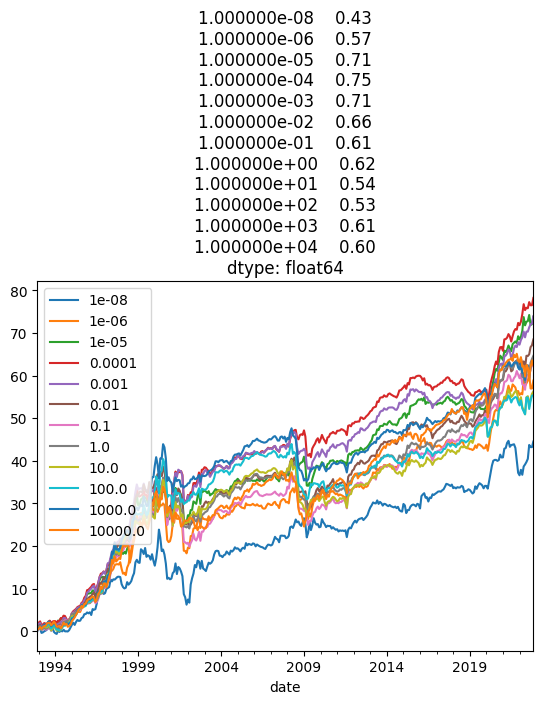

In [22]:
optimal_random_features, split = efficient_portfolio_oos(raw_factor_returns=random_feature_managed_returns)

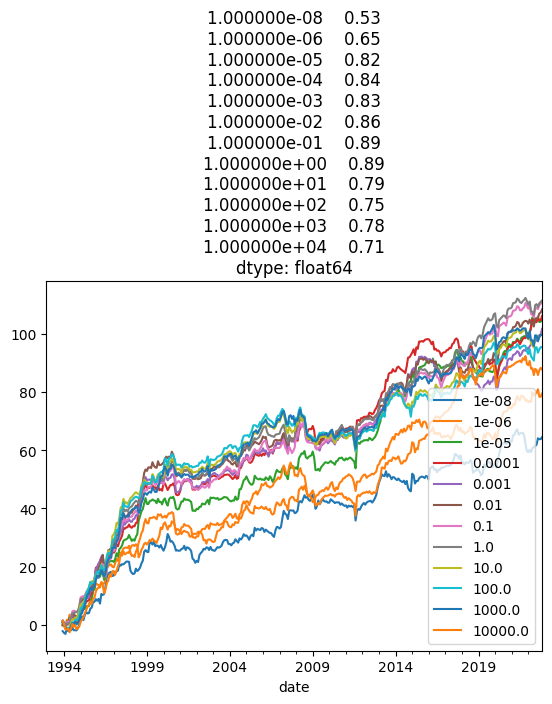

In [23]:
# does risk management help
vol_managed_rf = volatility_managed_returns(optimal_random_features, 12)
vol_managed_rf.cumsum().plot()
sr = sharpe_ratio(vol_managed_rf)
plt.title(f'{sr}')
plt.show()

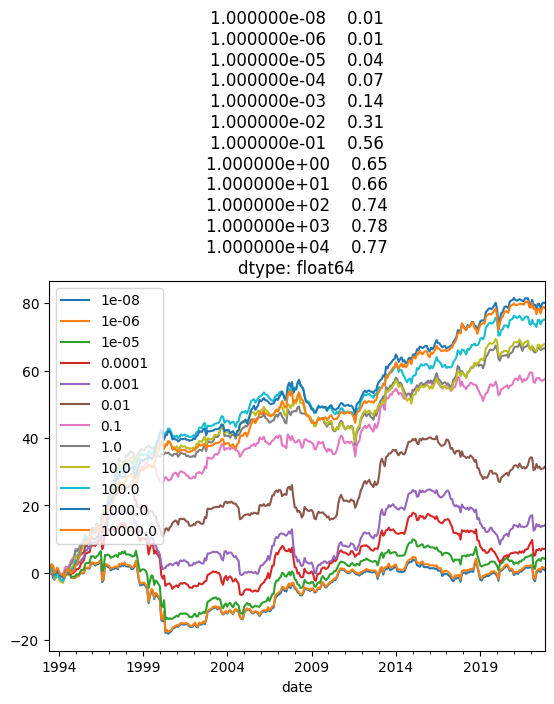

In [24]:
# what if we manage each of them individually:
individually_managed = volatility_managed_returns(random_feature_managed_returns, 12).dropna()
optimal_random_features_individually_managed, split = efficient_portfolio_oos(raw_factor_returns=individually_managed)

In [25]:
tstats = pd.concat([regression_with_tstats(predicted_variable=optimal_random_features[col].fillna(0),
                                           explanatory_variables=pd.concat([simple_managed_benchmark.fillna(0).iloc[split:], optimal[10]], axis=1).fillna(0).reindex(optimal_random_features[col].index).fillna(0)) for col in optimal], axis=1)
tstats.columns = optimal.columns
print(tstats)

       1.000000e-08  1.000000e-06  1.000000e-05  1.000000e-04  1.000000e-03  \
const           1.5           1.8           2.4           2.5           2.0   
0.0            -1.5          -1.4          -1.0          -0.9          -1.9   
10.0            1.8           1.7           1.3           1.4           2.3   

       1.000000e-02  1.000000e-01  1.000000e+00  1.000000e+01  1.000000e+02  \
const           1.6           1.5           1.6           0.9           0.5   
0.0            -2.8          -3.6          -3.9          -4.5          -4.8   
10.0            3.2           3.9           4.2           4.8           5.1   

       1.000000e+03  1.000000e+04  
const           0.4           0.7  
0.0            -2.6           0.9  
10.0            3.2          -0.2  


In [26]:
tstats = pd.concat([regression_with_tstats(predicted_variable=vol_managed_rf[col].fillna(0),
                                           explanatory_variables=pd.concat([simple_managed_benchmark.fillna(0).iloc[split:], optimal[10]], axis=1).fillna(0).reindex(vol_managed_rf[col].index).fillna(0)) for col in vol_managed_rf], axis=1)
tstats.columns = optimal.columns
print(tstats)

       1.000000e-08  1.000000e-06  1.000000e-05  1.000000e-04  1.000000e-03  \
const           1.8           2.1           2.8           2.5           2.3   
0.0            -0.8          -0.9          -0.5          -0.6          -1.2   
10.0            1.0           1.2           0.9           1.0           1.7   

       1.000000e-02  1.000000e-01  1.000000e+00  1.000000e+01  1.000000e+02  \
const           2.5           3.3           3.3           2.3           1.6   
0.0            -2.5          -3.7          -4.2          -6.0          -7.1   
10.0            3.0           4.2           4.7           6.6           7.7   

       1.000000e+03  1.000000e+04  
const           1.1           1.0  
0.0            -4.0           1.1  
10.0            5.0          -0.4  


In [27]:
tstats = pd.concat([regression_with_tstats(predicted_variable=optimal_random_features_individually_managed[col].fillna(0),
                                           explanatory_variables=pd.concat([simple_benchmark.fillna(0).iloc[split:], optimal[10]], axis=1).fillna(0).reindex(optimal_random_features_individually_managed.index).fillna(0)) for col in optimal_random_features_individually_managed], axis=1)
tstats.columns = optimal.columns
print(tstats)

       1.000000e-08  1.000000e-06  1.000000e-05  1.000000e-04  1.000000e-03  \
const          -0.0          -0.0          -0.0          -0.2          -0.1   
0.0            -2.2          -2.2          -2.1          -1.3          -1.4   
10.0            1.8           1.8           2.1           2.4           2.7   

       1.000000e-02  1.000000e-01  1.000000e+00  1.000000e+01  1.000000e+02  \
const           0.4           1.1           1.0           0.5           0.7   
0.0            -4.1          -5.8          -4.3          -2.7          -1.0   
10.0            5.5          10.0          10.7          11.8          16.4   

       1.000000e+03  1.000000e+04  
const           1.1           1.0  
0.0             1.0           1.6  
10.0           27.9          22.8  


In [28]:
signals = stock_data[momentum_columns]
labels = stock_data['r_1']
date_split = '2000-01-01'

train_signals = signals.loc[(signals.index.get_level_values('date') <= '2000-01-01') & (signals.index.get_level_values('date') >= '1970-01-01')]
train_returns = stock_data['r_1'].loc[(signals.index.get_level_values('date') <= '2000-01-01') & (signals.index.get_level_values('date') >= '1970-01-01')]

test_signals = signals.loc[signals.index.get_level_values('date') > '2000-01-01']
test_returns = stock_data['r_1'].loc[signals.index.get_level_values('date') > '2000-01-01']

In [29]:
def train_loader(signals, returns):
  """
  This is a special DataLoader designed to work with portfolio optimization.
  It creates mini-batches using every month of data
  """
  dates = signals.index.get_level_values('date')
  unique_dates = dates.unique()
  for date in unique_dates:
    #print(f'running date {date}')
    yield torch.tensor(signals.loc[dates == date].values), torch.tensor(returns.loc[dates == date].values)

In [30]:
class FlexibleMLP(nn.Module):
    def __init__(self, layers: list, scale: float=1.):
        """
        param: layers = list of integers
        """
        super(FlexibleMLP, self).__init__()

        self.layers = nn.ModuleList()
        self.activations = nn.ModuleList()

        for i in range(len(layers) - 1):
            layer = nn.Linear(layers[i], layers[i+1])

            # LeCun initialization
            nn.init.normal_(layer.weight, mean=0.0, std=scale * np.sqrt(1 / layers[i]))
            nn.init.normal_(layer.bias, mean=0.0, std=0 * np.sqrt(1 / layers[i]))

            self.layers.append(layer)
            # Add ReLU activation after each layer except the last
            if i < len(layers) - 2:
                self.activations.append(nn.ReLU())
            else:
                # Placeholder for the last layer's activation
                self.activations.append(nn.Identity())

    def forward(self, x, return_last_hidden=False):
        last_hidden = None

        for layer, activation in zip(self.layers[:-1], self.activations[:-1]):
            x = activation(layer(x))
            last_hidden = x  # Update last_hidden at each hidden layer

        # Apply the last layer without ReLU (or Identity for the placeholder)
        x = self.layers[-1](x)

        if return_last_hidden:
            return x, last_hidden
        return x

In [31]:
def mssr_loss(output, target):
  """
  MSRR = Maximal Sharpe Ratio Regression
  This is our MSRR loss through which we evaluate the quality of predictions
  Every mini batch is a month. So,
  (output * target.view((output.shape[0], 1))).sum() is the return on the
  portfolio in that particular month (.sum() is over stocks)
  """
  dist = 1 - (output * target.view((output.shape[0], 1))).sum()
  msrr = torch.pow(dist, 2)
  return msrr

def set_seed(seed_value=42):
    """Set seed for reproducibility."""
    np.random.seed(seed_value)  # Set NumPy seed
    torch.manual_seed(seed_value)  # Set PyTorch seed
    random.seed(seed_value)  # Set Python random seed

    # If you are using CUDA:
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)  # For multi-GPU
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

In [32]:
signals

,,ret_12_1,ret_3_1,ret_6_1,ret_9_1,ret_12_7,ret_1_0
id,date,,,,,,
10145,1963-01-31,0.007293,0.248271,0.404300,0.305466,-0.089951,-0.256906
10161,1963-01-31,0.004052,0.161134,0.070042,0.329582,0.107780,0.294890
10225,1963-01-31,-0.410859,-0.079530,-0.228155,-0.358521,-0.329822,-0.179558
10241,1963-01-31,0.342788,0.006224,0.007628,0.326367,0.448136,-0.219613
10321,1963-01-31,0.435170,-0.249654,0.033981,0.356913,0.375203,0.466851
...,...,...,...,...,...,...,...
93089,2022-11-30,0.000923,-0.008704,0.172396,0.236387,0.066904,-0.099637
93094,2022-11-30,0.467308,0.269551,-0.132552,0.412042,0.476511,-0.158537
93096,2022-11-30,0.329423,0.257599,0.311719,0.409686,0.304698,-0.112351


In [33]:
# Proceed with the rest of the setup (loss, optimizer) and training loop as before
# Loss and optimizer
ridge_penalty = 0.01  # Regularization strength
set_seed(42)  # Fixing the seed

width = 64
model = FlexibleMLP([signals.shape[1], width, 1], scale=1.) # re-initializing weights !!!
criterion = mssr_loss # this is our custom loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.000001)  # Using Adam optimizer for better performance with deep networks

# Training loop
set_seed(0)  # Fixing the seed
num_epochs = 40  # You might need more epochs for a deep network
for epoch in range(num_epochs):
    for inputs, targets in train_loader(train_signals, train_returns):
        # each mini batch is a month of data
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets) # this is (1- portfolio return)^2

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if (epoch+1) % 2 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [2/40], Loss: 0.0889
Epoch [4/40], Loss: 0.0907
Epoch [6/40], Loss: 0.0923
Epoch [8/40], Loss: 0.0935
Epoch [10/40], Loss: 0.0945
Epoch [12/40], Loss: 0.0953
Epoch [14/40], Loss: 0.0958
Epoch [16/40], Loss: 0.0962
Epoch [18/40], Loss: 0.0963
Epoch [20/40], Loss: 0.0962
Epoch [22/40], Loss: 0.0959
Epoch [24/40], Loss: 0.0955
Epoch [26/40], Loss: 0.0949
Epoch [28/40], Loss: 0.0942
Epoch [30/40], Loss: 0.0933
Epoch [32/40], Loss: 0.0922
Epoch [34/40], Loss: 0.0911
Epoch [36/40], Loss: 0.0898
Epoch [38/40], Loss: 0.0884
Epoch [40/40], Loss: 0.0869


Text(0.5, 1.0, 'sr=0    0.13\ndtype: float64')

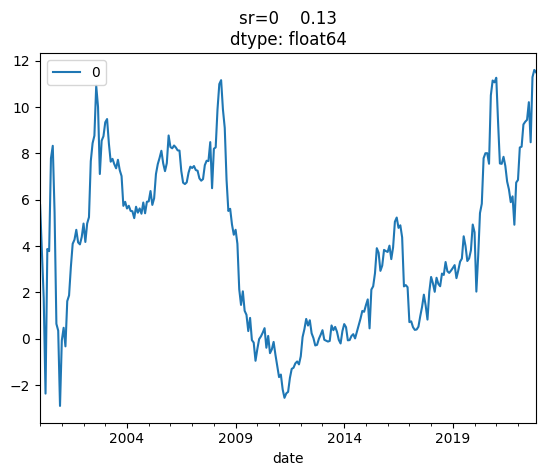

In [34]:
model.eval()
test_data_predictions = model(torch.tensor(test_signals.values))
managed_returns = build_managed_returns(returns=test_returns, signals=pd.DataFrame(test_data_predictions.detach().numpy(), index=test_returns.index))
managed_returns.cumsum().plot()
plt.title(f'sr={sharpe_ratio(managed_returns)}')

In [35]:
class ExpandedMultiHeadAttention(nn.Module):
    def __init__(self, d_input, num_heads):
        super().__init__()
        self.d_input = d_input
        self.num_heads = num_heads
        self.d_proj = d_input * num_heads  # total projection size

        # Linear layers to project to multi-head space
        self.W_q = nn.Linear(d_input, self.d_proj)
        self.W_k = nn.Linear(d_input, self.d_proj)
        self.W_v = nn.Linear(d_input, self.d_proj)

        # Final output layer
        self.output_layer = nn.Linear(self.d_proj, 1)

        self.reset_parameters()

    def reset_parameters(self):
        nn.init.xavier_uniform_(self.W_q.weight)
        nn.init.xavier_uniform_(self.W_k.weight)
        nn.init.xavier_uniform_(self.W_v.weight)
        nn.init.xavier_uniform_(self.output_layer.weight)
        nn.init.zeros_(self.W_q.bias)
        nn.init.zeros_(self.W_k.bias)
        nn.init.zeros_(self.W_v.bias)
        nn.init.zeros_(self.output_layer.bias)

    def forward(self, X, return_attention=False):
        N, d = X.shape
        assert d == self.d_input

        Q = self.W_q(X)  # (N, h*d)
        K = self.W_k(X)
        V = self.W_v(X)

        Q = Q.view(N, self.num_heads, self.d_input)  # (N, h, d)
        K = K.view(N, self.num_heads, self.d_input)
        V = V.view(N, self.num_heads, self.d_input)

        # Compute attention weights (scalar per head)
        Q_ = Q.unsqueeze(2)  # (N, h, 1, d)
        K_ = K.unsqueeze(3)  # (N, h, d, 1)
        attn_scores = torch.matmul(Q_, K_) / (self.d_input ** 0.5)  # (N, h, 1, 1)
        attn_weights = torch.sigmoid(attn_scores).squeeze(-1).squeeze(-1)  # (N, h)

        # Apply attention weights to V
        attn_output = attn_weights.unsqueeze(-1) * V  # (N, h, d)
        attn_output = attn_output.reshape(N, self.d_proj)  # (N, h*d)

        y = self.output_layer(attn_output)  # (N, 1)

        if return_attention:
            return y, attn_weights
        return y

In [36]:
def plot_scalar_attention_weights(attn_weights, idx=0, title=None):
    """
    Plot scalar attention weights (shape: N x h) for a specific sample.
    """
    weights = attn_weights[idx].detach().cpu()
    num_heads = weights.shape[0]

    plt.figure(figsize=(num_heads, 3))
    plt.bar(range(num_heads), weights)
    plt.xticks(range(num_heads), [f"Head {i+1}" for i in range(num_heads)])
    plt.ylabel("Attention Weight")
    if title:
        plt.title(title)
    plt.show()

Output shape: torch.Size([16, 1])
Attention shape: torch.Size([16, 4])


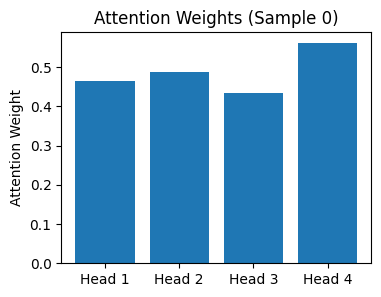

In [37]:
d = 6
h = 4
N = 16

model = ExpandedMultiHeadAttention(d_input=d, num_heads=h)
X = torch.randn(N, d)

y_pred, attn_weights = model(X, return_attention=True)
print("Output shape:", y_pred.shape)
print("Attention shape:", attn_weights.shape)

plot_scalar_attention_weights(attn_weights, idx=0, title="Attention Weights (Sample 0)")

In [38]:
N, d = 32, 6    # small, indivisible d
h = 5           # 5 heads, total projection size = 30
X = torch.randn(N, d)

mha = ExpandedMultiHeadAttention(d_input=d, num_heads=h)
y_pred = mha(X)   # shape: (N, 1)
print(y_pred.shape)

torch.Size([32, 1])


In [39]:
# Proceed with the rest of the setup (loss, optimizer) and training loop as before
# Loss and optimizer
set_seed(42)  # Fixing the seed
model = ExpandedMultiHeadAttention(d_input=signals.shape[1], num_heads=1) # re-initializing weights !!!
criterion = mssr_loss # this is our custom loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)  # Using Adam optimizer for better performance with deep networks

# Training loop
set_seed(0)  # Fixing the seed
num_epochs = 40  # You might need more epochs for a deep network
for epoch in range(num_epochs):
    for inputs, targets in train_loader(train_signals, train_returns):
        # each mini batch is a month of data
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets) # this is (1- portfolio return)^2

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if (epoch+1) % 2 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [2/40], Loss: 0.0009
Epoch [4/40], Loss: 0.0001
Epoch [6/40], Loss: 0.0019
Epoch [8/40], Loss: 0.0057
Epoch [10/40], Loss: 0.0109
Epoch [12/40], Loss: 0.0169
Epoch [14/40], Loss: 0.0234
Epoch [16/40], Loss: 0.0300
Epoch [18/40], Loss: 0.0363
Epoch [20/40], Loss: 0.0421
Epoch [22/40], Loss: 0.0472
Epoch [24/40], Loss: 0.0514
Epoch [26/40], Loss: 0.0546
Epoch [28/40], Loss: 0.0568
Epoch [30/40], Loss: 0.0579
Epoch [32/40], Loss: 0.0580
Epoch [34/40], Loss: 0.0571
Epoch [36/40], Loss: 0.0552
Epoch [38/40], Loss: 0.0526
Epoch [40/40], Loss: 0.0492


In [40]:
class ExpandedMultiHeadAttention(nn.Module):
    """
    Multi-Head Attention across N samples (no sequence dimension).
    This module computes attention weights between all samples in the batch,
    similar to standard self-attention across tokens in a sequence.

    Each head sees all N samples as both queries and keys.
    """

    def __init__(self, d_input, num_heads, init_fn_dict=None, scale_dict=None):
        """
        Parameters:
        - d_input (int): Input feature dimension.
        - num_heads (int): Number of attention heads.
        - init_fn_dict (dict): Optional dict mapping parameter names to init functions.
        - scale_dict (dict): Optional dict mapping parameter names to scale factors.
        """
        super().__init__()

        self.d_input = d_input                   # Original input dimension
        self.num_heads = num_heads               # Number of attention heads
        self.d_proj = d_input * num_heads        # Projected dimension after multi-head concat

        # Linear projections for Q, K, V. These will be reshaped into heads later
        self.W_q = nn.Linear(d_input, self.d_proj)
        self.W_k = nn.Linear(d_input, self.d_proj)
        self.W_v = nn.Linear(d_input, self.d_proj)

        # Final output layer to map multi-head output to scalar prediction
        self.output_layer = nn.Linear(self.d_proj, 1)

        # Optional dictionaries for custom parameter initialization and scaling
        self.init_fn_dict = init_fn_dict or {}
        self.scale_dict = scale_dict or {}

        # Initialize weights
        self.reset_parameters()

    def reset_parameters(self):
        """
        Applies parameter-specific initialization and scaling.
        Falls back to Xavier initialization and 1.0 scale if unspecified.
        """

        def apply_init(name, param):
            # Use user-specified init function or default to Xavier
            init_fn = self.init_fn_dict.get(name, nn.init.xavier_uniform_)
            init_fn(param)

        def apply_scale(name, param):
            # Multiply weights by a custom scalar (if provided)
            scale = self.scale_dict.get(name, 1.0)
            param.data.mul_(scale)

        # Initialize weights and biases for each projection layer
        for name, layer in zip(['W_q', 'W_k', 'W_v', 'output'],
                               [self.W_q, self.W_k, self.W_v, self.output_layer]):
            apply_init(name + '_weight', layer.weight)  # Initialize weights
            nn.init.zeros_(layer.bias)                  # Zero the bias
            apply_scale(name + '_weight', layer.weight) # Scale the weights

    def forward(self, X, return_attention=False):
        """
        Forward pass of multi-head self-attention.

        Parameters:
        - X: (N, d_input) input tensor
        - return_attention (bool): if True, also return attention weights

        Returns:
        - y: (N, 1) output predictions
        - attn_weights (optional): (N, num_heads, N) attention scores for each head
        """
        N, d = X.shape
        assert d == self.d_input, "Input feature size mismatch"

        # Project input into Q, K, V for all heads: shape (N, h * d_input)
        Q = self.W_q(X)
        K = self.W_k(X)
        V = self.W_v(X)

        # Reshape each into (N, h, d_input) so each head has its own d_input-dim space
        Q = Q.view(N, self.num_heads, self.d_input)
        K = K.view(N, self.num_heads, self.d_input)
        V = V.view(N, self.num_heads, self.d_input)

        # Transpose to (h, N, d_input): each head is a separate batch
        Q = Q.permute(1, 0, 2)
        K = K.permute(1, 0, 2)
        V = V.permute(1, 0, 2)

        # Compute raw attention scores with scaled dot product:
        #   (h, N, d) x (h, d, N) -> (h, N, N)
        attn_scores = torch.matmul(Q, K.transpose(-2, -1)) / (self.d_input ** 0.5)

        # Apply softmax over keys (last dimension): (h, N, N)
        attn_weights = F.softmax(attn_scores, dim=-1)

        # Apply attention weights to values:
        #   (h, N, N) x (h, N, d) -> (h, N, d)
        attn_output = torch.matmul(attn_weights, V)

        # Recombine heads: (h, N, d) -> (N, h, d)
        attn_output = attn_output.permute(1, 0, 2)

        # Flatten across heads: (N, h, d) -> (N, h * d)
        attn_output = attn_output.reshape(N, self.d_proj)

        # Final output projection: (N, h * d) -> (N, 1)
        y = self.output_layer(attn_output)

        # Return predictions and optionally attention weights (transpose to (N, h, N))
        return (y, attn_weights.permute(1, 0, 2)) if return_attention else y

In [41]:
def plot_attention_heatmaps(attn_weights, title=None, idx_range=None):
    """
    Plot attention matrices for each head.

    Parameters:
    - attn_weights: (N, num_heads, N) tensor of attention scores
    - title: optional title for the full figure
    - idx_range: tuple (start, end), optional crop of matrix
    """
    N, num_heads, _ = attn_weights.shape

    # Optionally crop attention matrix to a slice of samples
    if idx_range:
        start, end = idx_range
        attn_weights = attn_weights[start:end, :, start:end]
        N = end - start

    # Create one subplot per head
    fig, axes = plt.subplots(1, num_heads, figsize=(4 * num_heads, 4))
    if num_heads == 1:
        axes = [axes]  # handle single-head case

    for h in range(num_heads):
        ax = axes[h]
        # Show attention weight heatmap: rows = queries, cols = keys
        im = ax.imshow(attn_weights[:, h, :].detach().cpu(), cmap="viridis", aspect='auto')
        ax.set_title(f"Head {h + 1}")
        ax.set_xlabel("Key Index")
        ax.set_ylabel("Query Index")
        fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    if title:
        plt.suptitle(title)
    plt.tight_layout()
    plt.show()

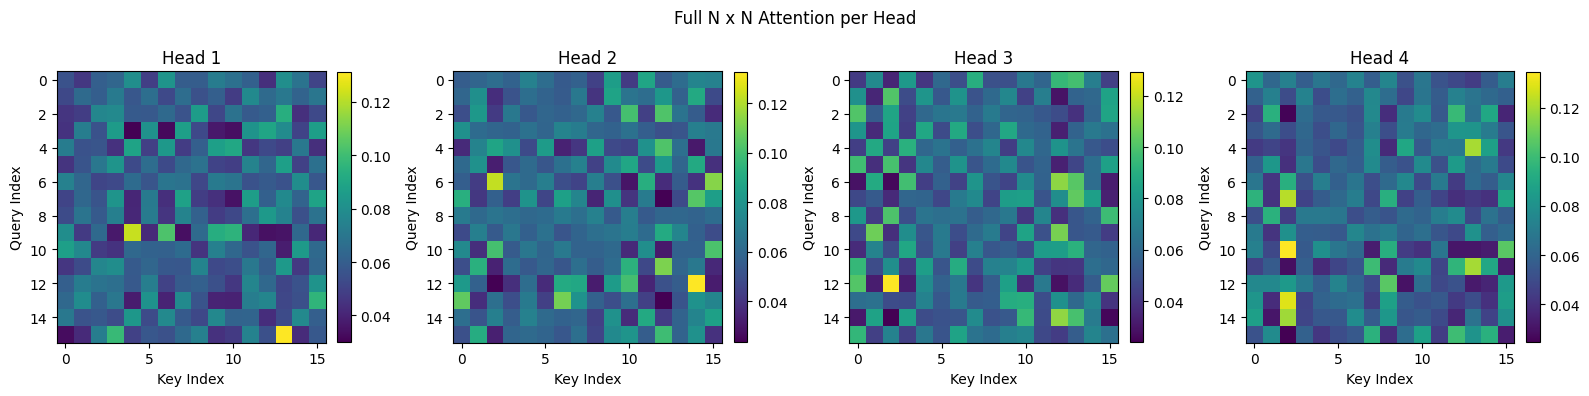

In [42]:
d = 6
h = 4
N = 16

model = ExpandedMultiHeadAttention(d_input=d, num_heads=h)
X = torch.randn(N, d)

y_pred, attn_weights = model(X, return_attention=True)  # attn_weights: (N, h, N)
plot_attention_heatmaps(attn_weights, title="Full N x N Attention per Head")

Output shape: torch.Size([16, 1])
Attention shape: torch.Size([16, 4, 16])


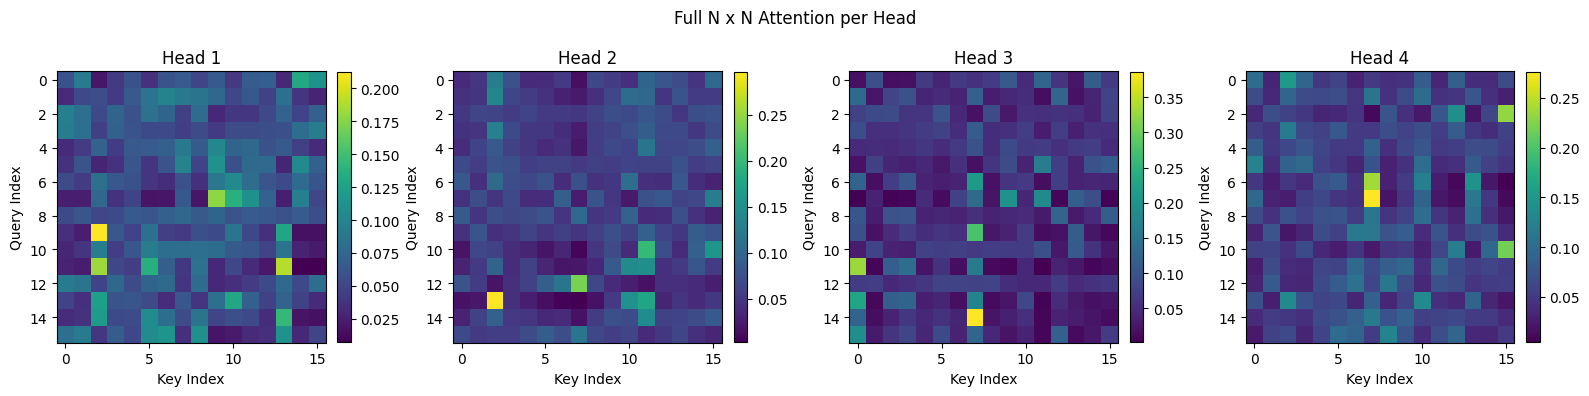

In [43]:
# Model config
d = 6         # Input dimension
h = 4         # Number of heads
N = 16        # Batch size

# Optional: custom initialization and scaling
init_fns = {
  'W_q_weight': nn.init.kaiming_uniform_,
  'W_k_weight': nn.init.xavier_normal_,
  'W_v_weight': lambda w: nn.init.constant_(w, 0.5),
  'output_weight': nn.init.xavier_uniform_,
}

scales = {
  'W_q_weight': 0.9,
  'W_v_weight': 0.1
}

# Create model
model = ExpandedMultiHeadAttention(d_input=d, num_heads=h,
                                  init_fn_dict=init_fns,
                                  scale_dict=scales)

# Dummy input
X = torch.randn(N, d)

# Forward pass
y_pred, attn_weights = model(X, return_attention=True)
print("Output shape:", y_pred.shape)        # (N, 1)
print("Attention shape:", attn_weights.shape)  # (N, h)
plot_attention_heatmaps(attn_weights, title="Full N x N Attention per Head")

In [44]:
# Optional: custom initialization and scaling
init_fns = {
  'W_q_weight': nn.init.kaiming_uniform_,
  'W_k_weight': nn.init.xavier_normal_,
  'W_v_weight': lambda w: nn.init.constant_(w, 0.),
  'output_weight': nn.init.xavier_uniform_,
}

scales = {
  'W_q_weight': 0.05,
  'W_v_weight': 0.01,
  'W_k_weight': 0.01,
  'output_weight': 10.
}

#heads
h = 1

# Create model
model = ExpandedMultiHeadAttention(d_input=signals.shape[1],
                                   num_heads=h,
                                  init_fn_dict=init_fns,
                                  scale_dict=scales)
criterion = mssr_loss # this is our custom loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # Using Adam optimizer for better performance with deep networks

# Training loop
set_seed(10)  # Fixing the seed
num_epochs = 60  # You might need more epochs for a deep network
for epoch in range(num_epochs):
    for inputs, targets in train_loader(train_signals, train_returns):
        # each mini batch is a month of data
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets) # this is (1- portfolio return)^2

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if (epoch+1) % 2 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [2/60], Loss: 1.2017
Epoch [4/60], Loss: 1.2874
Epoch [6/60], Loss: 1.4883
Epoch [8/60], Loss: 1.7675
Epoch [10/60], Loss: 2.0029
Epoch [12/60], Loss: 2.1743
Epoch [14/60], Loss: 2.3027
Epoch [16/60], Loss: 2.4062
Epoch [18/60], Loss: 2.4943
Epoch [20/60], Loss: 2.5698
Epoch [22/60], Loss: 2.6312
Epoch [24/60], Loss: 2.6755
Epoch [26/60], Loss: 2.6998
Epoch [28/60], Loss: 2.7031
Epoch [30/60], Loss: 2.6886
Epoch [32/60], Loss: 2.6630
Epoch [34/60], Loss: 2.6161
Epoch [36/60], Loss: 2.5539
Epoch [38/60], Loss: 2.4745
Epoch [40/60], Loss: 2.3780
Epoch [42/60], Loss: 2.2640
Epoch [44/60], Loss: 2.1348
Epoch [46/60], Loss: 1.9916
Epoch [48/60], Loss: 1.8460
Epoch [50/60], Loss: 1.6965
Epoch [52/60], Loss: 1.5477
Epoch [54/60], Loss: 1.4000
Epoch [56/60], Loss: 1.2586
Epoch [58/60], Loss: 1.1372
Epoch [60/60], Loss: 1.0344


100%|██████████| 54/54 [00:00<00:00, 121.77it/s]


Text(0.5, 1.0, 'sr=0   -0.57\ndtype: float64')

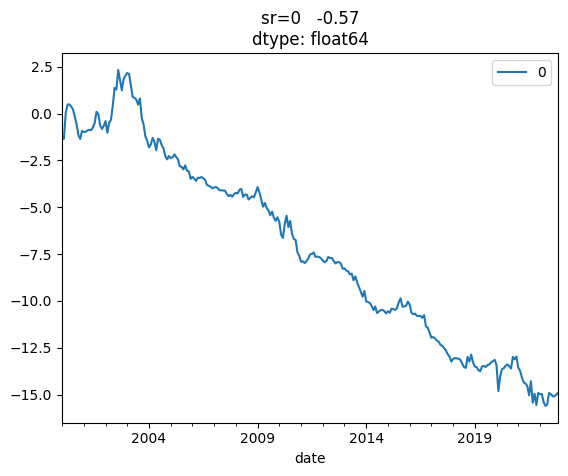

In [ ]:
from tqdm import tqdm  # 用于显示进度条
model.eval()
# 1. 设置合适的批次大小（根据你的显存容量调整，例如 1024/2048/4096）
BATCH_SIZE = 2048

# 2. 准备测试数据（转换为 NumPy 数组，确保是 float 类型）
test_signals_np = test_signals.values.astype(np.float32)

# 3. 初始化用于收集预测结果的列表
all_predictions = []

# 4. 分批推理
num_batches = (len(test_signals_np) - 1) // BATCH_SIZE + 1
for i in tqdm(range(num_batches)):
    # 提取当前批次的数据
    start_idx = i * BATCH_SIZE
    end_idx = min((i + 1) * BATCH_SIZE, len(test_signals_np))
    batch_data = torch.tensor(test_signals_np[start_idx:end_idx], dtype=torch.float32)
    
    # 推理（关闭梯度计算以节省内存）
    with torch.no_grad():
        batch_pred = model(batch_data)
    
    # 收集结果（移动到 CPU 以释放 GPU 显存）
    all_predictions.append(batch_pred.cpu().detach().numpy())

# 5. 合并所有批次的预测结果
test_data_predictions = np.concatenate(all_predictions, axis=0)

managed_returns = build_managed_returns(returns=test_returns, signals=pd.DataFrame(test_data_predictions, index=test_returns.index))
managed_returns.cumsum().plot()
plt.title(f'sr={sharpe_ratio(managed_returns)}')